In [2]:
import os
from os.path import join
import pandas as pd
import numpy as np
from pydeseq2.preprocessing import deseq2_norm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy.io import mmread
from scipy.stats import kendalltau

In [3]:
def spearman_count(quant_dir_ont, quant_dir_pacbio):
    
    
    #d = ["H9_directRNA (ONT)", "SQ2_HiFi (PacBio)"]
    d = ["H9_1DcDNA", "RSII"]
    data_dict = {
    "H9_1DcDNA": ("cdna", quant_dir_ont),
    "RSII": ("", quant_dir_pacbio)
    }
    ground_truth = {"H9_1DcDNA":{}, "RSII": {}}
    t = {"H9_1DcDNA":{}, "RSII": {}}
    
    
    #get the ground truth values
    txp = pd.read_csv(f"{quant_dir_ont}/ground_truth/all_transcript_name.csv", header=None, sep="\t")
    first_parts = [s.split('.')[0] for s in list(txp[0])]
    first_parts_df = pd.DataFrame(first_parts)
    first_parts_df.columns = ["Txp"]
    
    
    for k, (v, quant_dir) in data_dict.items():
        if k == "H9_1DcDNA":
            ground_truth[k] = pd.read_csv(f"{quant_dir}/ground_truth/{k}_ground_truth.csv", header=None, sep="\t")
            ground_truth[k].columns = ["Txp", "Ground_Truth"]
        elif k == "RSII":
            ground_truth[k] = pd.read_csv(f"{quant_dir}/ground_truth/{k}_ground_truth.csv", sep="\t")
            ground_truth[k].columns = ["Txp", "Ground_Truth"]
            ground_truth[k]["Txp"] = [s.split('.')[0] for s in list(ground_truth[k]["Txp"])]
    
    for k in t.keys():
        t[k] = pd.merge(first_parts_df, ground_truth[k], left_on="Txp", right_on="Txp", how="left")
        t[k] = t[k].fillna(0)      
    
    
    
    #read in the count files   
    oarfish_align_cov = {k: {} for k in d}
    oarfish_align_nocov = {k: {} for k in d}
    NanoCount = {k: {} for k in d}
    NanoCount_nofilt = {k: {} for k in d}
    bambu = {k: {} for k in d}
    kallisto = {k: {} for k in d}
    isoquant = {k: {} for k in d}
    espresso = {k: {} for k in d}
    transigner = {k: {} for k in d}
    
    
    for k, (v, quant_dir) in data_dict.items():
        oarfish_align_cov[k] = pd.read_csv(join(quant_dir, 'oarfish_align_quant', k, v, 'out_cov.quant'), sep="\t")
        oarfish_align_cov[k]['tname'] = oarfish_align_cov[k]['tname'].apply(lambda x: x.split('.')[0])
        ###########################################################################################
        oarfish_align_nocov[k] = pd.read_csv(join(quant_dir, 'oarfish_align_quant', k, v, 'out_nocov.quant'), sep="\t")
        oarfish_align_nocov[k]['tname'] = oarfish_align_nocov[k]['tname'].apply(lambda x: x.split('.')[0])
        ##########################################################################################
        NanoCount[k] = pd.read_csv(join(quant_dir, 'NanoCount_quant', k, v, 'isoform_expression_estimates'), sep="\t")
        NanoCount[k].rename(columns={NanoCount[k].columns[2]: "num_reads"}, inplace=True)
        NanoCount[k]['transcript_name'] = NanoCount[k]['transcript_name'].apply(lambda x: x.split('.')[0])
        NanoCount[k] = NanoCount[k].groupby(NanoCount[k]['transcript_name'])['num_reads'].sum().reset_index()
        ###########################################################################################
        NanoCount_nofilt[k] = pd.read_csv(join(quant_dir, 'NanoCount_quant_nofilt', k, v, 'isoform_expression_estimates'), sep="\t")
        NanoCount_nofilt[k].rename(columns={NanoCount_nofilt[k].columns[2]: "num_reads"}, inplace=True)
        NanoCount_nofilt[k]['transcript_name'] = NanoCount_nofilt[k]['transcript_name'].apply(lambda x: x.split('.')[0])
        NanoCount_nofilt[k] = NanoCount_nofilt[k].groupby(NanoCount_nofilt[k]['transcript_name'])['num_reads'].sum().reset_index()
        ###########################################################################################
        bambu[k] = pd.read_csv(join(quant_dir, 'bambu_quant', k, v, 'counts_transcript.txt'), sep="\t")
        bambu[k].rename(columns={bambu[k].columns[2]: "num_reads"}, inplace=True)
        bambu[k]['TXNAME'] = bambu[k]['TXNAME'].apply(lambda x: x.split('.')[0])
        bambu[k] = bambu[k].groupby(bambu[k]['TXNAME'])['num_reads'].sum().reset_index()
        ###########################################################################################
        kallisto[k] = pd.read_csv(join(quant_dir, 'lr-kallisto', k, v, 'bus_quant_tcc.tsv'), sep="\t")
        kallisto[k].rename(columns={kallisto[k].columns[1]: "num_reads"}, inplace=True)
        kallisto[k]["transcript_id"] = kallisto[k]['transcript_id'].apply(lambda x: x.split('.')[0])
        kallisto[k] = kallisto[k].groupby(kallisto[k]['transcript_id'])['num_reads'].sum().reset_index()
        ###########################################################################################
        espresso[k] = pd.read_csv(join(quant_dir, 'espresso_quant', k, v, 'sam_sorted_N2_R0_abundance.esp'), sep="\t")
        espresso[k].rename(columns={espresso[k].columns[3]: "num_reads"}, inplace=True)
        espresso[k]['transcript_ID'] = espresso[k]['transcript_ID'].apply(lambda x: x.split('.')[0])
        espresso[k] = espresso[k].groupby(espresso[k]['transcript_ID'])['num_reads'].sum().reset_index()
        ###########################################################################################
        transigner[k] = pd.read_csv(join(quant_dir, 'transigner_quant', k, v, 'abundances.tsv'), sep="\t", header=None)
        transigner[k].columns = ['Txp', 'abundance', 'num_reads']
        transigner[k].rename(columns={transigner[k].columns[2]: "num_reads"}, inplace=True)
        transigner[k]['Txp'] = transigner[k]['Txp'].apply(lambda x: x.split('.')[0])
        transigner[k] = transigner[k].groupby(transigner[k]['Txp'])['num_reads'].sum().reset_index()
        ###########################################################################################
        isoquant[k] = pd.read_csv(join(quant_dir, 'IsoQuant_quant', k, v, 'OUT/OUT.transcript_counts.tsv'), sep="\t")
        isoquant[k]['#feature_id'] = isoquant[k]['#feature_id'].str.split('.').str[0]
        isoquant[k].rename(columns={isoquant[k].columns[1]: "num_reads"}, inplace=True)
        isoquant[k] = isoquant[k].groupby(isoquant[k]['#feature_id'])['num_reads'].sum().reset_index()
        


    m = {k: {} for k in d}
    
    for v in d:
        #print(v)
        m[v] = pd.merge(oarfish_align_cov[v], t[v], left_on="tname", right_on="Txp", how="left", suffixes=('_align_cov', ''))
        m[v] = m[v].rename(columns={"num_reads" : "oarfish (cov)"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(oarfish_align_nocov[v], m[v], left_on="tname", right_on="Txp", how="right", suffixes=('_align_nocov', ''))
        m[v] = m[v].rename(columns={"num_reads" : "oarfish (nocov)"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(NanoCount[v], m[v], left_on="transcript_name", right_on="Txp", how="right", suffixes=('_NanoCount', ''))
        m[v] = m[v].rename(columns={"num_reads" : "NanoCount"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(NanoCount_nofilt[v], m[v], left_on="transcript_name", right_on="Txp", how="right", suffixes=('_NanoCount_nofilt', ''))
        m[v] = m[v].rename(columns={"num_reads" : "NanoCount (nofilt)"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(bambu[v], m[v], left_on="TXNAME", right_on="Txp", how="right", suffixes=('_bambu', ''))
        m[v] = m[v].rename(columns={"num_reads" : "bambu"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(kallisto[v], m[v], left_on="transcript_id", right_on="Txp", how="right", suffixes=('_kallisto', ''))
        m[v] = m[v].rename(columns={"num_reads" : "lr-kallisto"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(espresso[v], m[v], left_on="transcript_ID", right_on="Txp", how="right", suffixes=('_espresso', ''))
        m[v] = m[v].rename(columns={"num_reads" : "ESPRESSO"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(transigner[v], m[v], left_on="Txp", right_on="Txp", how="right", suffixes=('_transigner', ''))
        m[v] = m[v].rename(columns={"num_reads" : "TranSigner"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = pd.merge(isoquant[v], m[v], left_on="#feature_id", right_on="Txp", how="right", suffixes=('_isoquant', ''))
        m[v] = m[v].rename(columns={"num_reads" : "IsoQuant"})
        #print(len(m[v]["tname"]))
        #--------------------------------------------------------------------------------------------------
        m[v] = m[v].fillna(0)
    

    columns_to_compare = ["oarfish (cov)", "oarfish (nocov)", "NanoCount", "NanoCount (nofilt)", "bambu", "lr-kallisto", "TranSigner", "IsoQuant", "ESPRESSO"]
    epsilon = 1e-10
    
    output = {'spearman': {}, 'pearson': {}, 'CCC': {}, 'Kendall': {}, 'RMSE': {}, 'NRMSE': {}, 'MARD': {}}
    for method in output.keys():
        tmp = {}
        for k, v in m.items():
            #print("k:", k)
            #print("v:", v.columns)
            mix = "Ground_Truth"
            if method == "spearman":
                tmp[k] = v.loc[:, ["oarfish (cov)", "oarfish (nocov)", "NanoCount", "NanoCount (nofilt)", "bambu", "lr-kallisto", "TranSigner", "IsoQuant", "ESPRESSO", "Ground_Truth"]].corr(method="spearman")[mix]
                tmp[k] = tmp[k][:-1]
            #---------------------------------------------------------------------------------------
            if method == "pearson":
                pseudocount = 1.0
                log2_columns = v.loc[:, ["oarfish (cov)", "oarfish (nocov)", "NanoCount", "NanoCount (nofilt)", "bambu", "lr-kallisto", "TranSigner", "IsoQuant", "ESPRESSO", "Ground_Truth"]].apply(lambda x: np.log2(x + pseudocount))
                tmp[k] = log2_columns.corr(method="pearson")[mix]
                tmp[k] = tmp[k][:-1]
            #---------------------------------------------------------------------------------------
            if method == "Kendall":
                Kendall_values = {}
                for column_name in columns_to_compare:
                    y_true = v[mix]
                    y_pred = v[column_name]
                    tau, p_value = kendalltau(y_true, y_pred)
                    Kendall_values[column_name] = tau
                tmp[k] = pd.Series(Kendall_values)
            #---------------------------------------------------------------------------------------
            if method == "CCC":
                pseudocount = 1.0
                log2_columns = v.loc[:, ["oarfish (cov)", "oarfish (nocov)", "NanoCount", "NanoCount (nofilt)", "bambu", "lr-kallisto", "TranSigner", "IsoQuant", "ESPRESSO", "Ground_Truth"]].apply(lambda x: np.log2(x + pseudocount))
                pearson_corr = log2_columns.corr(method="pearson")[mix]
                
                ccc_correlation = {}
                for column_name in columns_to_compare:
                    y_true = log2_columns[mix]
                    y_pred = log2_columns[column_name]
                    #obtain the mean value
                    mean_true = np.mean(y_true)
                    mean_pred = np.mean(y_pred)
                    #obtain the standard deviation
                    std_true = np.std(y_true)
                    std_pred = np.std(y_pred)
                    ccc_correlation[column_name] = (2 * pearson_corr[column_name] * std_true * std_pred) / \
                                                   (std_true**2 + std_pred**2 + (mean_true - mean_pred)**2)
                tmp[k] = pd.Series(ccc_correlation)
            #---------------------------------------------------------------------------------------
            if method == "RMSE":
                rmse_values = {}
                for column_name in columns_to_compare:
                    y_true = v[mix]
                    y_pred = v[column_name]
                    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                    rmse_values[column_name] = rmse
                tmp[k] = pd.Series(rmse_values)
            #---------------------------------------------------------------------------------------
            if method == "NRMSE":
                nrmse_values = {}
                for column_name in columns_to_compare:
                    y_true = v[mix]
                    y_pred = v[column_name]
                    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                    range_observed = np.mean(y_true)
                    nrmse_values[column_name] = rmse / range_observed
                tmp[k] = pd.Series(nrmse_values)
            #---------------------------------------------------------------------------------------
            if method == "MARD":
                mard_values = {}
                for column_name in columns_to_compare:
                    y_true = v[mix]
                    y_pred = v[column_name]
                    filtered_y_pred = y_pred
                    filtered_y_true = y_true
                    mard = np.mean(abs((filtered_y_pred - filtered_y_true) / (filtered_y_pred + filtered_y_true + epsilon)))
                    mard_values[column_name] = mard
                tmp[k] = pd.Series(mard_values)
            #---------------------------------------------------------------------------------------

            #---------------------------------------------------------------------------------------
        output[method] = pd.DataFrame(tmp)
    
    return output
    

In [4]:
def plot_function(tmp_list, fig_path):

    input_list = {}
    for k, v in tmp_list.items():
        input_list[k] = v.reset_index().rename(columns={'index': 'Method'})
    
    fig = plt.figure(figsize=(12, 12))  # Increased figure width to accommodate legend
    gs = GridSpec(5, 3, width_ratios=[1, 1, 0.5])  # Add an extra column for the legend

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[2, 0])
    ax6 = fig.add_subplot(gs[2, 1])
    ax7 = fig.add_subplot(gs[3, 0])
    ax8 = fig.add_subplot(gs[3, 1])
    ax9 = fig.add_subplot(gs[4, 0])
    ax10 = fig.add_subplot(gs[4, 1])
    #ax11 = fig.add_subplot(gs[5, 0])
    #ax12 = fig.add_subplot(gs[5, 1])
    ax_legend = fig.add_subplot(gs[:, 2])  # This will be the space for the legend
    ax_legend.axis('off')  # Turn off the axis for the legend

    #color_palette = sns.color_palette("dark", 12)
    color_palette = plt.get_cmap("tab10").colors[:12]
    marker_palette = ['s', '^', 'o', 'p', 'h', '+', 'x', '*', 'd', 'v', '>', '<', 'o']


    cl = 0
    ml = 0
    
    # For collecting legend handles and labels
    handles = []
    labels = []
    
    v1 = "H9_1DcDNA"
    v2 = "RSII"
    
    method_list = list(input_list['spearman']['Method'])
    
    for method in method_list:
        
        # Plot spearman vs pearson
        h1, = ax1.plot(input_list['pearson'][v1][input_list['pearson']['Method'] == method], input_list['spearman'][v1][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        ax2.plot(input_list['pearson'][v2][input_list['pearson']['Method'] == method], input_list['spearman'][v2][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        
        # Plot spearman vs CCC
        ax3.plot(input_list['CCC'][v1][input_list['CCC']['Method'] == method], input_list['spearman'][v1][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        ax4.plot(input_list['CCC'][v2][input_list['CCC']['Method'] == method], input_list['spearman'][v2][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        
        # Plot spearman vs Kendall
        ax5.plot(input_list['Kendall'][v1][input_list['Kendall']['Method'] == method], input_list['spearman'][v1][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        ax6.plot(input_list['Kendall'][v2][input_list['Kendall']['Method'] == method], input_list['spearman'][v2][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        
        # Plot Spearman vs 1/RMSE
        #ax7.plot([1/x for x in input_list['RMSE'][v1][input_list['RMSE']['Method']==method]], input_list['spearman'][v1][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        #ax8.plot([1/x for x in input_list['RMSE'][v2][input_list['RMSE']['Method']==method]], input_list['spearman'][v2][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        
        # Plot spearman vs 1/NRMSE
        ax7.plot([1/x for x in input_list['NRMSE'][v1][input_list['NRMSE']['Method'] == method]], input_list['spearman'][v1][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        ax8.plot([1/x for x in input_list['NRMSE'][v2][input_list['NRMSE']['Method'] == method]], input_list['spearman'][v2][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        
        # Plot spearman vs 1/MARD
        ax9.plot([1/x for x in input_list['MARD'][v1][input_list['MARD']['Method'] == method]], input_list['spearman'][v1][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        ax10.plot([1/x for x in input_list['MARD'][v2][input_list['MARD']['Method'] == method]], input_list['spearman'][v2][input_list['spearman']['Method'] == method], marker=marker_palette[ml], ms=10, linestyle='None', mfc= "None", mec=color_palette[cl], label=f"{method}")
        
        handles.extend([h1])
        labels.extend([f"{method}"])
        
        cl += 1
        ml += 1
    
    
    
    v1 = "ONT (1D-cDNA)"
    v2 = "PacBio (RSII)"
    # Set labels and titles for each subplot
    ax1.set_xlabel('Pearson (log(1 + x)) ', fontsize=10)
    ax1.set_ylabel('Spearman ρ', fontsize=10)
    ax1.set_title(f'{v1}', fontsize=10)
    ax1.grid(True)  # Add grid lines
    ax1.text(0.0, 1.05, 'a)', transform=ax1.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    ax2.set_xlabel('Pearson (log(1 + x)) ', fontsize=10)
    ax2.set_ylabel('Spearman ρ', fontsize=10)
    ax2.set_title(f'{v2}', fontsize=10)
    ax2.grid(True)  # Add grid lines
    ax2.text(0.0, 1.05, 'b)', transform=ax2.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    #=======================================================================================================
    
    ax3.set_xlabel('CCC', fontsize=10)
    ax3.set_ylabel('Spearman ρ', fontsize=10)
    ax3.set_title(f'{v1}', fontsize=10)
    ax3.grid(True)  # Add grid lines
    ax3.text(0.0, 1.05, 'c)', transform=ax3.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    ax4.set_xlabel('CCC', fontsize=10)
    ax4.set_ylabel('Spearman ρ', fontsize=10)
    ax4.set_title(f'{v2}', fontsize=10)
    ax4.grid(True)  # Add grid lines
    ax4.text(0.0, 1.05, 'd)', transform=ax4.transAxes, ha="left", va="center", fontsize=12, weight="bold")

    #=======================================================================================================
    
    ax5.set_xlabel('Kendall-τ', fontsize=10)
    ax5.set_ylabel('Spearman ρ', fontsize=10)
    ax5.set_title(f'{v1}', fontsize=10)
    ax5.grid(True)  # Add grid lines
    ax5.text(0.0, 1.05, 'e)', transform=ax5.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    ax6.set_xlabel('Kendall-τ', fontsize=10)
    ax6.set_ylabel('Spearman ρ', fontsize=10)
    ax6.set_title(f'{v2}', fontsize=10)
    ax6.grid(True)  # Add grid lines
    ax6.text(0.0, 1.05, 'f)', transform=ax6.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    #=======================================================================================================
    
    #ax7.set_xlabel('1/RMSE', fontsize=10)
    #ax7.set_ylabel('Spearman ρ', fontsize=10)
    #ax7.set_title(f'({v1})', fontsize=10)
    #ax7.grid(True)  # Add grid lines
    #ax7.text(0.0, 1.05, 'g)', transform=ax7.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    #
    #ax8.set_xlabel('1/RMSE', fontsize=10)
    #ax8.set_ylabel('Spearman ρ', fontsize=10)
    #ax8.set_title(f'({v2})', fontsize=10)
    #ax8.grid(True)  # Add grid lines
    #ax8.text(0.0, 1.05, 'h)', transform=ax8.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    #=======================================================================================================
    
    ax7.set_xlabel('1/NRMSE', fontsize=10)
    ax7.set_ylabel('Spearman ρ', fontsize=10)
    ax7.set_title(f'{v1}', fontsize=10)
    ax7.grid(True)  # Add grid lines
    ax7.text(0.0, 1.05, 'g)', transform=ax7.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    ax8.set_xlabel('1/NRMSE', fontsize=10)
    ax8.set_ylabel('Spearman ρ', fontsize=10)
    ax8.set_title(f'{v2}', fontsize=10)
    ax8.grid(True)  # Add grid lines
    ax8.text(0.0, 1.05, 'h)', transform=ax8.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    #=======================================================================================================
    
    ax9.set_xlabel('1/MARD', fontsize=10)
    ax9.set_ylabel('Spearman ρ', fontsize=10)
    ax9.set_title(f'{v1}', fontsize=10)
    ax9.grid(True)  # Add grid lines
    ax9.text(0.0, 1.05, 'i)', transform=ax9.transAxes, ha="left", va="center", fontsize=12, weight="bold")
    
    ax10.set_xlabel('1/MARD', fontsize=10)
    ax10.set_ylabel('Spearman ρ', fontsize=10)
    ax10.set_title(f'{v2}', fontsize=10)
    ax10.grid(True)  # Add grid lines
    ax10.text(0.0, 1.05, 'j)', transform=ax10.transAxes, ha="left", va="center", fontsize=12, weight="bold")


    
    # Tight layout and legend adjustment
    plt.tight_layout()
    ax_legend.legend(handles=handles, labels=labels, loc='center', fontsize=10)

    # Save the figure as a JPEG file
    directory = os.path.dirname(fig_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(fig_path, format='jpg', dpi=300, bbox_inches='tight')
    
    plt.show()


In [5]:
quant_ont = '/mnt/scratch2/zahra/sim_quant_time/nanosim_quant'
quant_pacbio = '/mnt/scratch2/zahra/sim_quant_time/tksm_quant_new_model'

output = {}

output = spearman_count(quant_ont, quant_pacbio)

In [6]:
combined_df = pd.concat(output.values(), axis=1, keys=output.keys())
combined_df = combined_df.round(2)
combined_df = combined_df.reset_index().rename(columns={'index': 'Method'})
combined_df = combined_df.reset_index(drop=True)

In [7]:
numeric_cols = combined_df.select_dtypes(include='number').columns
# Define the metric groups for correlation and error metrics
metric_groups = {
    'correlation': ['spearman', 'pearson', 'CCC', 'Kendall'],
    'error': ['RMSE', 'NRMSE', 'MARD']
}

correlation_columns = numeric_cols[numeric_cols.get_level_values(0).isin(metric_groups['correlation'])]
error_columns = numeric_cols[numeric_cols.get_level_values(0).isin(metric_groups['error'])]

max_values = combined_df[correlation_columns].max()
min_values = combined_df[error_columns].min()


# Apply the bold formatting for max/min values
def bold_max_min_values(val, metric, dataset):
    # Access max and min values for both metric and dataset using MultiIndex
    max_val = max_values.loc[(metric, dataset)] if (metric, dataset) in max_values.index else None
    min_val = min_values.loc[(metric, dataset)] if (metric, dataset) in min_values.index else None

    # Bold maximum values for correlation metrics
    if metric in metric_groups['correlation'] and val == max_val:
        return "\\textbf{" + f"{val:.2f}" + "}"
    # Bold minimum values for error metrics
    elif metric in metric_groups['error'] and val == min_val:
        return "\\textbf{" + f"{val:.2f}" + "}"
    
    return f"{val:.2f}"

#Apply formatting to each column
for metric, dataset in correlation_columns.union(error_columns):
    combined_df[(metric, dataset)] = combined_df[(metric, dataset)].apply(lambda x: bold_max_min_values(x, metric, dataset))

#Convert the updated DataFrame to LaTeX
latex_table = combined_df.to_latex(
    buf=None,
    column_format='lcccccccccccccc',  # Adjust according to the number of columns
    multirow=True,
    multicolumn=True,
    escape=False,  # Disable escaping so LaTeX formatting works
    caption="Metrics Comparison with Subdivisions",
    label="tab:metrics_comparison",
    index=False
)

#Print the LaTeX table
print(latex_table)

\begin{table}
\caption{Metrics Comparison with Subdivisions}
\label{tab:metrics_comparison}
\begin{tabular}{lcccccccccccccc}
\toprule
Method & \multicolumn{2}{r}{spearman} & \multicolumn{2}{r}{pearson} & \multicolumn{2}{r}{CCC} & \multicolumn{2}{r}{Kendall} & \multicolumn{2}{r}{RMSE} & \multicolumn{2}{r}{NRMSE} & \multicolumn{2}{r}{MARD} \\
 & H9_1DcDNA & RSII & H9_1DcDNA & RSII & H9_1DcDNA & RSII & H9_1DcDNA & RSII & H9_1DcDNA & RSII & H9_1DcDNA & RSII & H9_1DcDNA & RSII \\
\midrule
oarfish (cov) & \textbf{0.91} & \textbf{0.94} & \textbf{0.97} & \textbf{0.98} & \textbf{0.97} & \textbf{0.98} & \textbf{0.89} & \textbf{0.92} & \textbf{73.92} & \textbf{79.75} & \textbf{1.11} & \textbf{1.01} & \textbf{0.06} & \textbf{0.06} \\
oarfish (nocov) & 0.87 & 0.93 & \textbf{0.97} & \textbf{0.98} & \textbf{0.97} & \textbf{0.98} & 0.85 & 0.91 & 237.37 & 142.20 & 3.56 & 1.81 & 0.08 & \textbf{0.06} \\
NanoCount & 0.57 & 0.66 & 0.74 & 0.79 & 0.67 & 0.78 & 0.51 & 0.58 & 1118.02 & 789.02 & 16.76 & 10.02 &

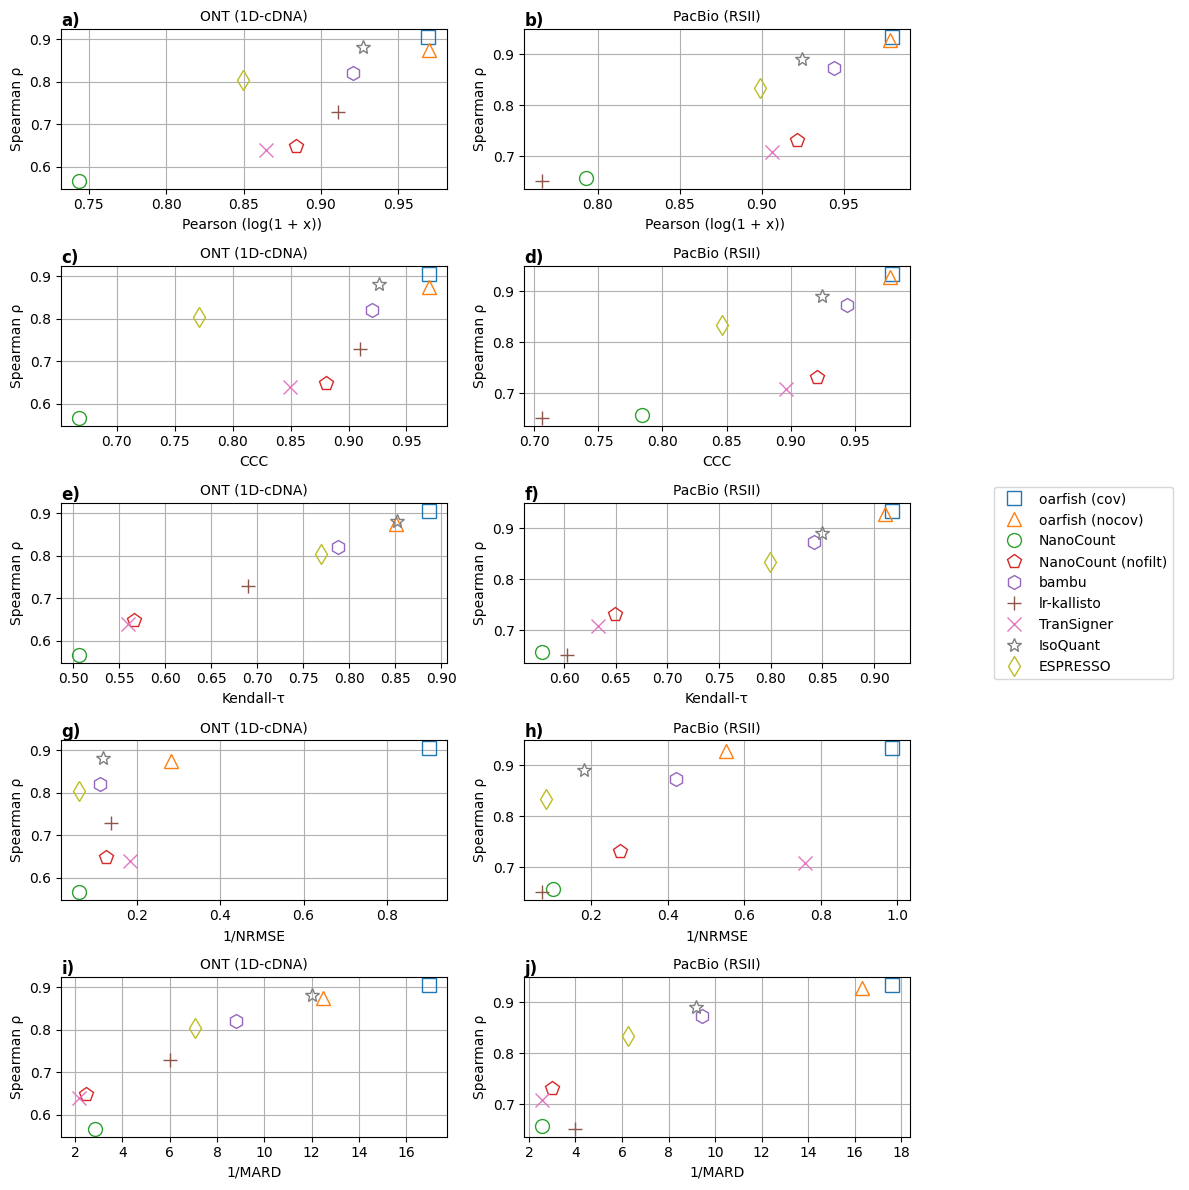

In [8]:
fig_path = '/mnt/scratch2/zahra/oarfish-paper-scripts/analysis_jupyter_notebook/figures/sim_data/cdna_RSII/compare_metrics.jpg'
plot_function(output, fig_path)